# Unit 4 - Detect Network Attacks Using Clustering Models

## A - Introduction

**What is a Clustering?**


***Clustering*** is an unsupervised machine learning technique that divides a population or data points into several groups. Data points in the same groups are more like other data points in the same group and dissimilar to the data points in different groups. 


![Clustering Example](imgs/clustering_example.jpg)


**Why Clustering?**
Clustering is crucial as it determines the intrinsic grouping among the unlabeled data present. There are no criteria for good clustering. It depends on the user, what is criteria they may use which satisfy their need. 

For instance, we could be interested in finding representatives for homogeneous groups (data reduction). Another example is when you want to look for “natural clusters” and describe their unknown properties (“natural” data types). Also, you could find valuable and suitable groupings (“useful” data classes) or find unusual data objects (outlier detection). Consequently, the clustering algorithm must make assumptions that constitute the similarity of points, and each assumption makes different and equally valid clusters.

**Applications of Clustering in different fields**
-	Market segmentation;
-	Social network analysis;
-	Search result grouping;
-	Medical imaging;
-	Image segmentation; and
-	Anomaly detection.

**Clustering Analysis in Cyber Security**

As we already cited, cybersecurity considers that the system is in an environment in the presence of an enemy, which continues plans to attack your data integrity and obfuscate your action in your system. Given this situation, it is a good idea to try to group similar data in a cluster, making it possible to, after this pre-processing, you start to try to set labels in the data.

There are a set of papers that presents ideas on how to use clustering in cybersecurity problems. To increase your knowledge, you can reed these materials:

- [Using Cluster Analysis for Comprehensive Threat Detection](http://secbi.com/white-paper-form/SecBI_White_Paper_Using_Cluster_Analysis_for_Comprehensive_Threat_Detection.pdf)
- [System log clustering approaches for cyber security applications: A survey](https://www.sciencedirect.com/science/article/pii/S0167404820300250)

## B - Clustering Analysis Process

The general process to analyze a clustering following these steps:

- Collecting Data;
- Prepare data;
- Create similarity metric;
- Run clustering algorithm; and
- Interpret results and adjust your clustering.

![Clustering Analysis Process](imgs/clustering_analysis_process.PNG)

**Collecting Data**
As in any ML solution, the first part of the work is to define which type and amount of data are required to achieve good results. In cyber, because of the malicious user presence, this challenge becomes much more complicated.

The first reason is that in a real scenario is required to install multiples sensors, which generate similar data most of the time; however, a specific slot of time can generate evidence of an attack that needs to be fused to identify the malicious event correctly.

It is a hard task because it requires multiple skills; for example, system operational, network, machine language, reverse engineering, etc.

To simplify the task of a Data Scientist to discover how to use different and innovative ML techniques inside the cyber domain, DARPA created a dataset named NSL-KDD. The first version, which was named KDD99, had a set of duplicate information, and its size is a little big, which makes it hard to apply it in ML systems.

DARPA has collected over nine weeks and consists of raw tcpdump traffic in a local area network (LAN) that simulates a typical United States Air Force LAN environment. Some network attacks were deliberately carried out during the recording period. 

The general attacks categories were NLS-KDD has are:
- dos: Denial of Service;
- r2l: Unauthorized access from remote servers;
- u2r: Privilege escalation attempts;
- probe: Brute-force probing attacks; and
- normal: normal traffic (no attacks).

However, in the dataset, you did not find this classification; you find the name of the attack, as it is presented in the Figure below:  

![NSL-KDD Attack Types](imgs/ndd_attack_types.jpg)


**Prepare Data**

As with any ML problem, you must normalize, scale, and transform feature data. While clustering however, you must additionally ensure that the prepared data lets you accurately calculate the similarity between examples.

**Create Similarity Metric**

Before a clustering algorithm can group data, it needs to know how similar pairs of examples are. You quantify the similarity between examples by creating a similarity metric. Creating a similarity metric requires you to carefully understand your data and how to derive similarity from your features.

**Run Clustering Algorithm**

A clustering algorithm uses the similarity metric to cluster data. This course focuses on k-means.

**Interpret Results and Adjust**

Checking the quality of your clustering output is iterative and exploratory because clustering lacks “truth” that can verify the output. You verify the result against expectations at the cluster-level and the example-level. Improving the result requires iteratively experimenting with the previous steps to see how they affect the clustering.

## C - Clustering using Python

### C.1 - Load Dataset

The first task is to load the dataset, adjusting it to be consume by the ML model. As we already used, the easiest way to load dataset is from pandas read_csv method. In this case, we will pass the columns names to our dataset.

In [1]:
import pandas as pd

def load_dataset(trainfile, testfile,
                 header_names):
    train_df = pd.read_csv(trainfile, names=header_names)
    print('train shape:',train_df.shape)
    
    test_df = pd.read_csv(testfile, names=header_names)
    print('test shape:',test_df.shape)
    
    return train_df, test_df


#load dataset
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
                    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
                    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
                    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
                    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
                    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
                    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                    'dst_host_srv_diff_host_rate',
                    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                    'dst_host_srv_rerror_rate',
                    'attack_type', 'success_pred']

train_file_name = 'KDDTrain+.txt'
test_file_name='KDDTest+.txt'

train_df, test_df= load_dataset(train_file_name, test_file_name,header_names)


train shape: (125973, 43)
test shape: (22544, 43)


As we previously cited, the dataset does not contain the attack categories (*dos, r2l, u2r, probe, and normal*), but the attack's types. The number of attack types (40) is unfeasible to use the clustering approach because the model has its performance-sensitive as the number of required clusters.

A new file is required to solve this situation, which contains the type and categories, like a dictionary.

Its format is presented in the Figure. In this Figure, the first column is the attack type and the second is the category.

![Training Attack Dictionary](imgs/data_dict.PNG)


To create the dictionary, we define a method, which append the value 'benign' to normal data in the dataset and after import the file.


In [2]:
from collections import defaultdict

def load_dictionary(dictionary_name):
    category = defaultdict(list)
    category['benign'].append('normal')

    with open(dictionary_name, 'r') as f:
        for line in f.readlines():
            attack, cat = line.strip().split(' ')
            category[cat].append(attack)

    mapping_dict = dict((v, k)
                        for k in category for v in category[k])
    return mapping_dict

#load dictionary
dict_file = 'resources/ndd/training_attack_types.txt'
dicta = load_dictionary(dict_file)

Now, we need to insert this new field in the imported daframe and drop the unnecessary fields.

In [3]:
def adjust_datasets(train_ds, test_ds, dicta, att_type_lb, catg_attk_lab,drop_list_label):
    train_ds[catg_attk_lab] = train_ds[att_type_lb].map(lambda x: dicta[x])
    test_ds[catg_attk_lab] = test_ds[att_type_lb].map(lambda x: dicta[x])

    for i in range(0, len(drop_list_label)):
        train_ds.drop([drop_list_label[i]], axis=1, inplace=True)
        test_ds.drop([drop_list_label[i]], axis=1, inplace=True)

drop_list_label=[]
drop_list_label.append('success_pred')
adjust_datasets(train_df,test_df,dicta,'attack_type', 'attack_category',drop_list_label)

Following we will define a set of index list that contains the type of values.

In [4]:
import numpy as np
def getColunssByClass(header_names):
    nominal_idx = [1, 2, 3]
    bin_idx = [6, 11, 13, 14, 20, 21]
    numeric_idx = list(set(range(41)).difference(nominal_idx).difference(bin_idx))
    col_names = np.array(header_names)
    nominal_cols = col_names[nominal_idx].tolist()
    binary_cols = col_names[bin_idx].tolist()
    numeric_cols = col_names[numeric_idx].tolist()
    return nominal_cols, binary_cols, numeric_cols

nominal_cols, binary_cols, numeric_cols = getColunssByClass(header_names)


### C.2 - Prepare the Data

#### C.2.1- Data Cleaning

As the data is already imported to a Panda DataFrame, our current task is cleaning it and prepare to be consumed by an ML system. First; we will look for inconsistent columns. For example, when we check the 'su_attempt' column, we can see 3 possible values: 0, 1,2. As each line is related to one transaction, in each transaction, you can have only two values: successful (1) and failure (0); it does not make sense the value 2.

In [5]:
print(train_df.groupby(['su_attempted']).size())

su_attempted
0    125893
1        21
2        59
dtype: int64


Following, now we find that the field 'num_outbound_cmds' has a unique value. It does not make sense to include this field in the ML system, as it is a constant.

In [6]:
print(train_df.groupby(['num_outbound_cmds']).size())

num_outbound_cmds
0    125973
dtype: int64


So, I will fix the problems.

In [7]:
def cleaning_data (train_df, test_df, num_cols):
    train_df['su_attempted'].replace(2, 0, inplace=True)
    test_df['su_attempted'].replace(2, 0, inplace=True)
    print(train_df.groupby(['su_attempted']).size())

    train_df.drop('num_outbound_cmds', axis=1, inplace=True)
    test_df.drop('num_outbound_cmds', axis=1, inplace=True)
    num_cols.remove('num_outbound_cmds')

cleaning_data(train_df,test_df,numeric_cols)

su_attempted
0    125952
1        21
dtype: int64


Now we can plot the attack distribution in both datasets.

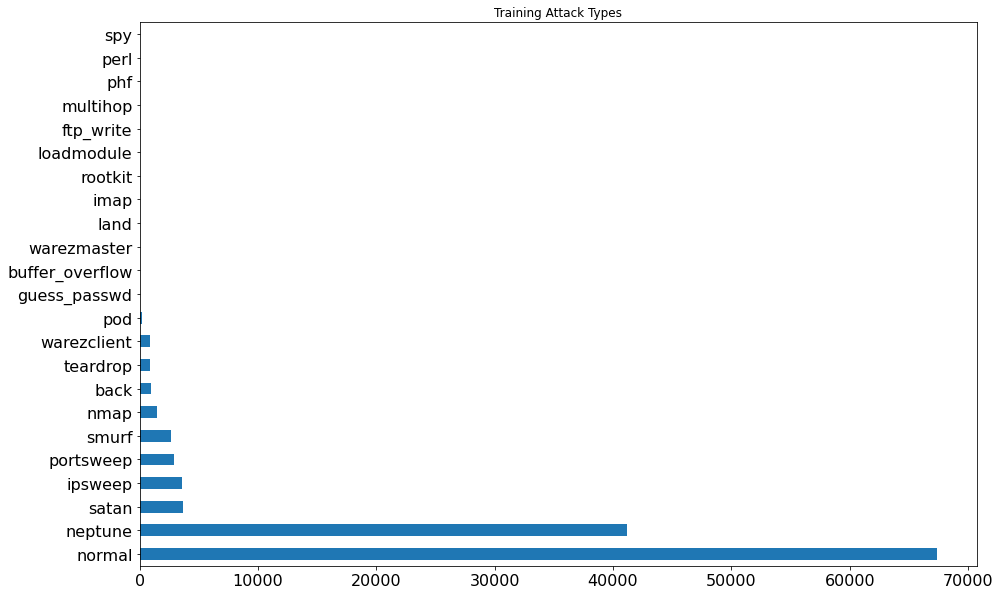

In [8]:
from matplotlib import pyplot as plt

def plot_dataset(dataset, label_name, title):
    plt_value = train_df[label_name].value_counts()
    plt_value.plot(kind='barh', figsize=(15, 10), fontsize=16, title=title)
    plt.show()

plot_dataset(train_df,'attack_type','Training Attack Types')

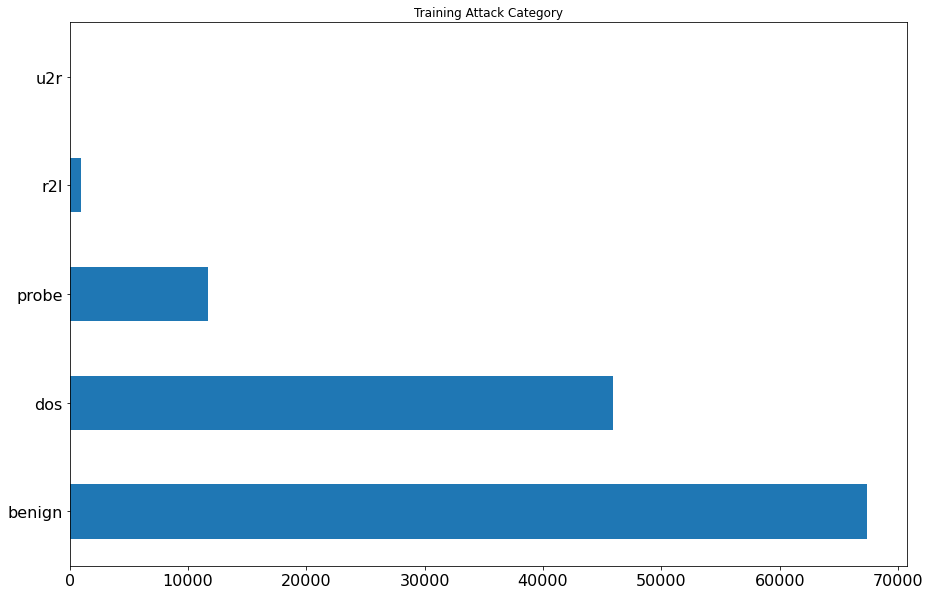

In [9]:
plot_dataset(train_df,'attack_category','Training Attack Category')

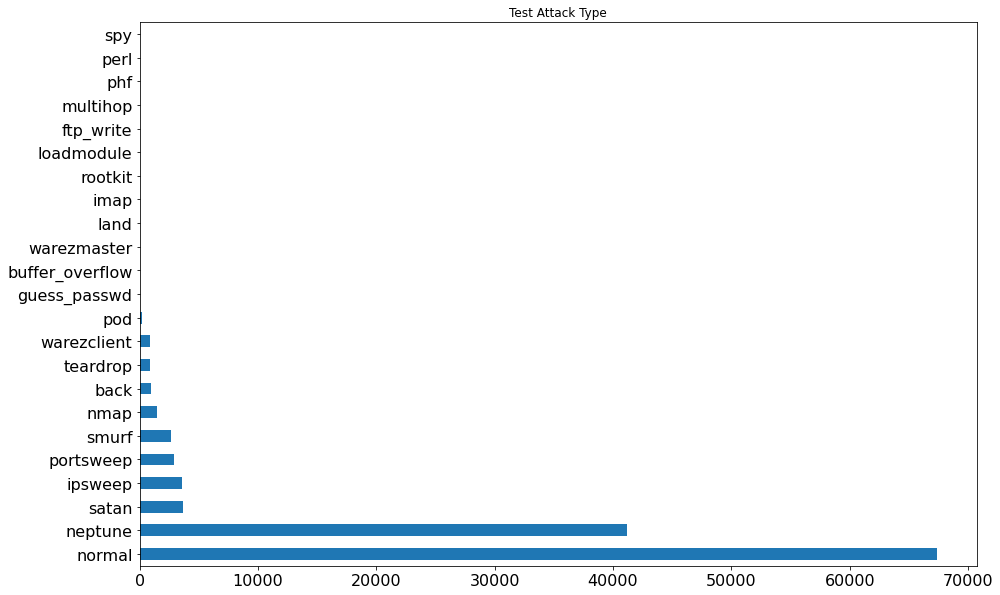

In [10]:
plot_dataset(test_df,'attack_type','Test Attack Type')

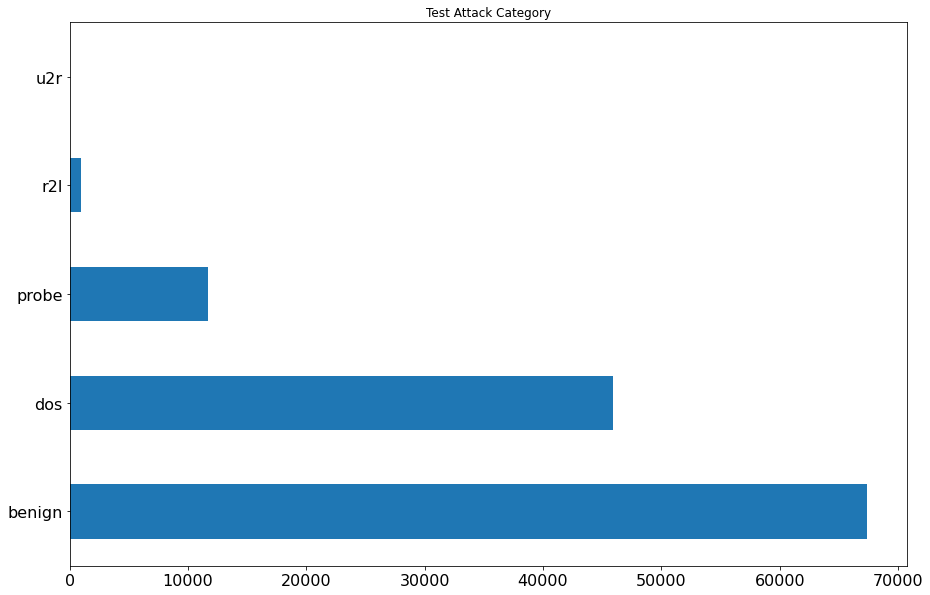

In [11]:
plot_dataset(test_df,'attack_category','Test Attack Category')

#### C.2.2- Adjusting and Normalizing Data

Our first task is to separate labels from the other fields and drop them because they are not required for clustering.

The next task is to convert the categorical data to numeric ones. The reason is that the ML models process better numeric values.

Ti support it, we can encode our categorical column using the **One-hot encoding**. This method spreads the values in a column to multiple flag columns and assigns 0 or 1 to them. These binary values express the relationship between grouped and encoded columns.

This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information. 

In [ ]:
def prepare_dataset(train_df, test_df, target_name,new_target_name, nominal_cols):

    #split the dataset into target_labels and values
    train_label = train_df[new_target_name]
    train_x_raw = train_df.drop([new_target_name, target_name], axis=1)

    test_label = test_df[new_target_name]
    test_x_raw = test_df.drop([new_target_name, target_name], axis=1)

    #convert the categorical values to numeric values
    combined_df_raw = pd.concat([train_x_raw, test_x_raw])
    combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    return train_x,train_label, test_x, test_label

train_x,train_label, test_x, test_label = prepare_dataset(train_df, test_df, 'attack_type','attack_category', nominal_cols)

Following this, we scaled the numeric values to rearrange them to be in the same range.

The scaling process that we will use is **standardization** (or **z-score normalization**); it scales the values while considering standard deviation. If the standard deviation of features is different, their range also will differ from each other. This reduces the effect of the outliers in the features.

In [ ]:
from sklearn.preprocessing import StandardScaler

def scalling(train_x, test_x, num_cols):
    # scaller  numeric values
    standard_scaler = StandardScaler().fit(train_x[num_cols])
    train_x[num_cols] = standard_scaler.transform(train_x[num_cols])
    test_x[num_cols] = standard_scaler.transform(test_x[num_cols])
    
    return train_x,  test_x

train_x,  test_x = scalling(train_x, test_x,numeric_cols)


The next step is encoding the labels, enabling that, after the clustering phase, we can convert the values to the initial classes that our database has (dos, r2l, u2r, probe, and normal).

In [ ]:
from sklearn.preprocessing import LabelEncoder

def enconding_label(train_label, test_label):
    # encoder the labels and transform in numeric values
    # it is impoirtant to analyze the result
    label_encoder = LabelEncoder()
    train_label_np = train_label.to_numpy()
    train_label_encod = label_encoder.fit_transform(train_label_np)

    test_label_np = test_label.to_numpy()
    test_label_encod = label_encoder.fit_transform(test_label_np)

    return train_label_encod, test_label_encod, label_encoder

train_label_encod, test_label_encod, label_encoder = enconding_label(train_label,test_label)

### C.3 - Run Clustering Algorithm

#### C.3.1 - Model Training

The last phases prepare the data to be consumed by the ML system. Now, our works are to training the selected cluster algorithm. 

We select the **K-means** as the clustering algorithm. K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean.

To implement this algorithm is required to select the K value, which means the number of clusters that the model will try to cluster the dataset.


In [ ]:
from sklearn.cluster import KMeans

def trainning (train_x, cluster_number):
    kmeans = KMeans(n_clusters=cluster_number, random_state=17).fit(train_x)
    return kmeans

number_of_cluster = 5
kmeans = trainning(train_x,number_of_cluster)

#### C.3.2. Predict Values

After the model is trained, the next step is to start to use the model to predict values. We will use the test_set to predict attacks using the clustering ML. Perceives that we have the predict labels and the predict encoded labels. We need the predict labels to be used in the ML; however, to plot, as we will see ahead, it is required the encoded values of label.

In [ ]:
def predict(kmeans,values_to_predict,label_encoder):
    pred_encoded_labels = kmeans.predict(values_to_predict)
    pred_labels = label_encoder.inverse_transform(pred_encoded_labels)
    return pred_labels, pred_encoded_labels

pred_labels, pred_encoded_labels = predict(kmeans,test_x,label_encoder)

### C.4 - Interpret Result and Adjust

Now, we can plot the result of our predictions. To plot the graph, we must use an algorithm that enables us to reduce the dimensionality of our results - the **Principal Component Analysis (PCA)**.

PCA is a dimensionality reduction method, feature extraction that transforms the data from *“d-dimensional space”* into a new coordinate system of dimension **p**, where **p <= d**.

ML models with many input variables or higher dimensionality tend to fail when operating on a higher input dataset. 
PCA helps in identifying relationships among different variables & then coupling them.  PCA involves transforming variables in the dataset into a new set of variables called PCs (Principal Components). 

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

def plot_results(data_x, data_label, pred_enconded_labels, label_encoder, title):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data_x)

    ds = pd.DataFrame(
        data=principalComponents,
        columns=["component_1", "component_2"],
    )

    ds["predicted_cluster"] = pred_enconded_labels
    ds["true_label"] = label_encoder.inverse_transform(data_label)

    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(8, 8))

    scat = sns.scatterplot(
        data=ds,
        x="component_1",
        y="component_2",
        s=50,
        hue="predicted_cluster",
        style="true_label",
        palette="Set2",

    )
    scat.set_title(title)
    plt.show()

plot_results(test_x, test_label_encod, pred_encoded_labels, label_encoder,'Clustering results from NDD dataset')

The result presents a set of problems in our clusterization. However, we need to remember that our idea is to check how data is similar, considering that an enemy can compromise previous dataset classification.

In the graph, you can see the clusters (colors) and the attack's classes (symbols). It is possible to check that different classes are clustered in the same group.

It indicates a good chance that the model does not cluster the data well, making required a formal evaluation of the model.

#### C.4.1. Testing the Model

The first task in the model evaluation is to calculate four metrics to cluster: *Silhouette Coefficient score, Rand Index, Completeness, Homogeinity, and V-Measure*.

The **Silhouette Coefficient** is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The best value is 1, and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

The **Rand Index** computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clustering. The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical.

**Homogeneity**: It estimates how many of the clusters predicted contain only members of a single class. 

**Completeness**: measures whether all members of a given class are assigned to the same cluster.

**Validity-Measure (V-Measure)**: is the harmonic mean of homogeneity and completeness.

*Homogeneity, Completeness, and V-Measure* have positive values between 0.0 and 1.0, larger values being desirable.


In [ ]:
from sklearn.metrics import completeness_score, \
    homogeneity_score, v_measure_score

from sklearn.metrics import silhouette_score, adjusted_rand_score

def calc_metrics(data_x,data_labels, predicted_encoded_labels):
    pca = PCA(n_components=2)
    pcomp = pca.fit_transform(data_x)
    print('Silhouette Coefficient score: {}'.format(silhouette_score(pcomp, predicted_encoded_labels)))
    print('Rand Index: {}'.format(adjusted_rand_score(data_labels, predicted_encoded_labels)))
    print('Completeness: {}'.format(completeness_score(data_labels, predicted_encoded_labels)))
    print('Homogeneity: {}'.format(homogeneity_score(data_labels, predicted_encoded_labels)))
    print('V-measure: {}'.format(v_measure_score(data_labels, predicted_encoded_labels)))
    print('Total number of features: {}'.format(len(data_x.columns)))

calc_metrics(test_x,test_label_encod,pred_encoded_labels)

Given the bad result of the metrics, we need to analyze if the model has a better result if I use a fewer cluster.

For this reason, I will plot what happens with the metrics if I use a different K.

In [ ]:
def plot_clustering_performance(data_x, data_label, label_encoder, range_init, range_final):
    # Empty lists to hold evaluation metrics
    silhouette_scores = []
    ari_scores = []
    homo_array = []
    compl_array = []
    v_meas_arrays = []

    for n in range(range_init, len(label_encoder.classes_)):
        # This set the number of components for pca,
        # but leaves other steps unchanged
        pca = PCA(n_components=2)
        pcomp = pca.fit_transform(data_x)

        kmeans = trainning(data_x,n)
        pred_labels, pred_encoded_labels= predict(kmeans,data_x,label_encoder)
        sil_coef=silhouette_score(pcomp, pred_encoded_labels)
        ari = adjusted_rand_score(data_label, pred_encoded_labels)
        compl = completeness_score(data_label, pred_encoded_labels)
        homo= homogeneity_score(data_label, pred_encoded_labels)
        v= v_measure_score(data_label, pred_encoded_labels)

        # Add metrics to their lists
        silhouette_scores.append(sil_coef)
        ari_scores.append(ari)
        compl_array.append(compl)
        homo_array.append(homo)
        v_meas_arrays.append(v)

    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(6, 6))
    plt.plot(
        range(range_init, len(label_encoder.classes_)),
        silhouette_scores,
        c="#008fd5",
        label="Silhouette Coefficient",
    )
    plt.plot(range(range_init, len(label_encoder.classes_)), ari_scores, c="b", label="ARI")

    plt.plot(range(range_init, len(label_encoder.classes_)), compl_array, c="g", label="Completeness Score")
    plt.plot(range(range_init, len(label_encoder.classes_)), homo_array, c="r", label="Homogeneity Score")
    plt.plot(range(range_init, len(label_encoder.classes_)), v_meas_arrays, c="gray", label="V Measure Score")

    plt.xlabel("n_components")
    plt.legend()
    plt.title("Clustering Performance\nas a Function of n_components")
    plt.tight_layout()
    plt.show()

plot_clustering_performance(test_x,test_label_encod,label_encoder,2,15)

In the graph, we can conclude that the best cost-effective solution is to use a K=3. The next step is to re-train the model, rerun it, and check the metrics.